### Download dataset

The mscoco dataset is pretty big (12 GB). We won't be using all of the data, but it makes matters easier to have everything together in one place. To help you download the data, you can run the following script (might need to open the script and follow step by step on windows). You will only need to run this once!

There is an [https://github.com/lichengunc/refer/blob/master/refer.py](API) to help you access and use the dataset. The main API is in the refer.py file. Run the following cell to import it, along with some other useful libraries (you may need to run pip to install them):

In [1]:
from refer import REFER
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import os
from PIL import Image as PImage # pillow

### Load the MSOCO dataset with referring expressions, show some stats. 

Notice that the datasets are already split into train, val, and test sets. This is to make it so everyone who uses the dataset can directly compare their results with each other. 

You will train using the `train` set. You will develop your model with the `val` set. After you think you are done, you will perform a final evaluation on the `test` dataset. 

In [2]:
data_root = 'coco'  # contains refclef, refcoco, refcoco+, refcocog and images
dataset = 'refcoco' 
splitBy = 'unc'
refer = REFER(data_root, dataset, splitBy)

loading dataset refcoco into memory...
creating index...
index created.
DONE (t=10.11s)


In [3]:
# print stats about the given dataset
print ('dataset [%s_%s] contains: ' % (dataset, splitBy))
ref_ids = refer.getRefIds()
image_ids = refer.getImgIds()
print ('%s expressions for %s refs in %s images.' % (len(refer.Sents), len(ref_ids), len(image_ids)))

print ('\nAmong them:')
if dataset == 'refclef':
    if splitBy == 'unc':
        splits = ['train', 'val', 'testA', 'testB', 'testC']
    else:
        splits = ['train', 'val', 'test']
elif dataset == 'refcoco':
    splits = ['train', 'val', 'test']
elif dataset == 'refcoco+':
    splits = ['train', 'val', 'test']
elif dataset == 'refcocog':
    splits = ['train', 'val']  # we don't have test split for refcocog right now.
    
for split in splits:
    ref_ids = refer.getRefIds(split=split)
    print ('%s refs are in split [%s].' % (len(ref_ids), split))

dataset [refcoco_unc] contains: 
142210 expressions for 50000 refs in 19994 images.

Among them:
42404 refs are in split [train].
3811 refs are in split [val].
3785 refs are in split [test].


In [4]:
words = []
for i in ref_ids:
    ref = refer.Refs[i]
    for sent in ref['sentences']:
        words += sent['tokens']
        
len(list(set(words)))

2362

### Example

- run the cells
- each sentence (i.e., referring expression) has an id with images and sub-images associated with it within a dictionary
- there is one object as a sub-image box denoted by the green box outline
- there are three referring expressions for that object

In [5]:
ref_ids = refer.getRefIds()
print(len(ref_ids))
ref_id = 35254 # pick a random ref_id
ref = refer.Refs[ref_id]

ref # a dictionary with all of the needed info for a referring expression+image

50000


{'sent_ids': [100272, 100273, 100274],
 'file_name': 'COCO_train2014_000000173056_1.jpg',
 'ann_id': 275551,
 'ref_id': 35254,
 'image_id': 173056,
 'split': 'train',
 'sentences': [{'tokens': ['white', 'brown', 'sheep', 'right'],
   'raw': 'white brown sheep right',
   'sent_id': 100272,
   'sent': 'white brown sheep right'},
  {'tokens': ['black', 'sheep', 'on', 'right'],
   'raw': 'black sheep on right',
   'sent_id': 100273,
   'sent': 'black sheep on right'},
  {'tokens': ['sheep', 'on', 'the', 'right'],
   'raw': 'sheep on the right',
   'sent_id': 100274,
   'sent': 'sheep on the right'}],
 'category_id': 20}

ref_id [35254] (ann_id [275551])
1. white brown sheep right
2. black sheep on right
3. sheep on the right


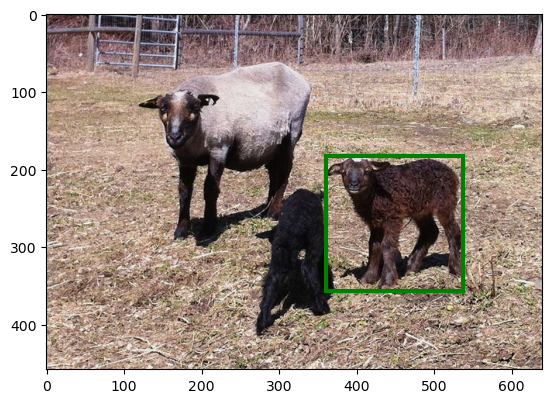

In [6]:
print ('ref_id [%s] (ann_id [%s])' % (ref_id, refer.refToAnn[ref_id]['id']))
# show the segmentation of the referred object

plt.figure()
refer.showRef(ref, seg_box='box')
plt.show()

The following function extracts the sub-image (i.e., within a bounding box) from within the image. 

In [7]:
def get_bounded_subimage(img_id, ann_id, xs=224,ys=224, show=False):
    
    bbox = refer.Anns[ann_id]['bbox']
    bbox = [int(b) for b in bbox]
    img = refer.Imgs[img_id]
   
    I = io.imread(os.path.join(refer.IMAGE_DIR, img['file_name']))
    sub = I[bbox[1]:bbox[1]+bbox[3],bbox[0]:bbox[0]+bbox[2]]
    if show:
        plt.figure()
        ax = plt.gca()
        ax.imshow(sub)
        plt.show()
    
    if len(sub) == 0: return None
    pim = PImage.fromarray(sub)
    pim2 = pim.resize((xs,ys), PImage.Resampling.LANCZOS)
    img = np.array(pim2)
    
    if len(img.shape) < 3: return None
    
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    
    return pim, img

### Example sub-image / object

- the following applies the sheep example to the above function
- notice that it extracts the sub-image so you can pass it through a convnet
- it returns a numpy representation of the image

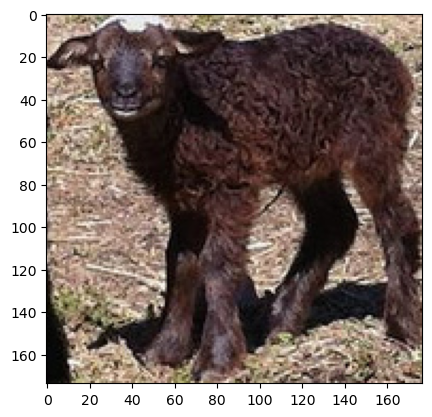

(<PIL.Image.Image image mode=RGB size=177x174>,
 array([[[[201, 175, 155],
          [214, 191, 170],
          [209, 188, 168],
          ...,
          [219, 192, 174],
          [197, 170, 150],
          [184, 157, 135]],
 
         [[197, 172, 151],
          [214, 192, 171],
          [220, 199, 179],
          ...,
          [202, 175, 156],
          [185, 158, 139],
          [182, 155, 136]],
 
         [[170, 145, 128],
          [165, 141, 125],
          [193, 169, 154],
          ...,
          [193, 165, 146],
          [206, 179, 159],
          [224, 198, 178]],
 
         ...,
 
         [[  4,   4,   5],
          [  7,   7,   8],
          [  8,   8,   7],
          ...,
          [115, 104,  98],
          [117, 104,  90],
          [145, 132, 117]],
 
         [[  6,   7,   6],
          [  8,   9,   8],
          [  9,   9,   8],
          ...,
          [228, 209, 195],
          [189, 172, 159],
          [144, 129, 116]],
 
         [[  9,   9,   9],
         

In [8]:
get_bounded_subimage(ref['image_id'], ref['ann_id'], show=True)

The following function `compute_posfeats` is a useful function that extracts a handful of extra features, for example, the area that the subimage takes, the x,y coordinates, among other things. Using this function isn't required, but using it will yield better results. 

In [9]:
def compute_posfeats(img_id, ann_id,):
    img = refer.Imgs[img_id]
    bb = refer.Anns[ann_id]['bbox']
    fname = os.path.join(refer.IMAGE_DIR, img['file_name'])
    if not os.path.isfile(fname): return None
    img = io.imread(fname)
    
    if len(img.shape) < 3: return None
    ih, iw, _ = img.shape
    x,y,w,h = bb
    # x1, relative
    x1r = x / iw
    # y1, relative
    y1r = y / ih
    # x2, relative
    x2r = (x+w) / iw
    # y2, relative
    y2r = (y+h) / ih
    # area
    area = (w*h) / (iw*ih)
    # ratio image sides (= orientation)
    ratio = iw / ih
    # distance from center (normalised)
    cx = iw / 2
    cy = ih / 2
    bcx = x + w / 2
    bcy = y + h / 2
    distance = np.sqrt((bcx-cx)**2 + (bcy-cy)**2) / np.sqrt(cx**2+cy**2)
    # done!
    return np.array([x1r,y1r,x2r,y2r,area,ratio,distance]).reshape(1,7)


In [10]:
# example using the sheep example on the compute_posfeats function
compute_posfeats(ref['image_id'], ref['ann_id']).flatten()

array([0.56284375, 0.39737991, 0.83945313, 0.77941048, 0.10567324,
       1.39737991, 0.34295148])

# Train

In [11]:
import os
import clip
import torch
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
clip_model, preprocess = clip.load('ViT-B/32', device)

device

'cpu'

In [12]:
from collections import defaultdict as dd
from tqdm import tqdm_notebook as tqdm
import random

In [13]:
words_as_classifiers = dd(list) # use something like this dictionary to store positive examples
train_ids = refer.getRefIds(split='train')

for i in tqdm(train_ids):#[:1000]):
    # first, get all of the training dat
    ref = refer.Refs[i]
    
    # for a single train_id, you can get its image_id and the ann_id (i.e., the referring expression)
    img_id = ref['image_id']
    ann_id = ref['ann_id']

    #then you'll need to get the bounded subimage by calling the get_bounded_subimage function.
    if (get_bounded_subimage(img_id, ann_id, show=False) is not None):
        img, _ = get_bounded_subimage(img_id, ann_id, show=False)
    
        #then, you'll need to pass that image through a convnet like you did for A6
        img = preprocess(img).unsqueeze(0).to(device)
        enc_img = clip_model.encode_image(img)
    
        #optionally, you can call the compute_posfeats function to get some additional features
        #concatenate these to the convnet output to form a single vector for this image
        pos_feats = compute_posfeats(img_id, ann_id)
        feature_vector = np.concatenate((enc_img.detach().numpy(), pos_feats), axis=1)

        #add this feature vector to a list of positive examples for each word in the referring expression
        # you may need to flatten() the feature vector
        for sent in ref['sentences']:
            for word in sent['tokens']:
                words_as_classifiers[word].append(feature_vector)


#for word in words_as_classifiers:
#    print(word, len(words_as_classifiers[word]))

/tmp/ipykernel_409678/1354840111.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(train_ids):#[:1000]):


  0%|          | 0/42404 [00:00<?, ?it/s]

In [14]:
def find_negative_samples(words_as_classifiers, word):
    words = list(words_as_classifiers.keys())
    words.remove(word)
    random_word = random.choice(words)
    random_vector = random.choice(words_as_classifiers[random_word])
    return random_vector
    
#find_negative_samples(words_as_classifiers,'shirt')

In [15]:
# now that we have all of the positive examples for all of the words, we  need to find negative examples for each word

num_negatives = 2 
threshold = 4

wac = {}

for word in tqdm(words_as_classifiers):
    pos_vectors = words_as_classifiers[word]
    num_pos_vectors = len(pos_vectors)
    if num_pos_vectors < threshold:
        continue
#     print(word, num_pos_vectors)
    neg_vectors = []
    # the number of negative examples should be a function of how many positive examples there are
    for i in range(0,num_negatives*num_pos_vectors):
        neg_vectors.append(find_negative_samples(words_as_classifiers,word))
    neg_vectors = np.array(neg_vectors)
    pos_vectors = np.array(pos_vectors)
    neg_vectors = neg_vectors.reshape(neg_vectors.shape[0], neg_vectors.shape[2])
    pos_vectors = pos_vectors.reshape(pos_vectors.shape[0], pos_vectors.shape[2])
#     print(pos_vectors.shape, neg_vectors.shape)
    X = np.concatenate((pos_vectors, neg_vectors), axis=0)
    
    y = np.concatenate((np.ones(num_pos_vectors), np.zeros(len(neg_vectors))))
    wac[word] = (X,y)
    

/tmp/ipykernel_409678/713139105.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for word in tqdm(words_as_classifiers):


  0%|          | 0/9350 [00:00<?, ?it/s]

In [16]:
#wac['the'][1][0].shape

In [17]:
import pickle

In [1]:
with open('wacModel.pickle', 'wb') as f:
    pickle.dump(wac, f, pickle.HIGHEST_PROTOCOL)

NameError: name 'pickle' is not defined

In [19]:
with open('wacModel.pickle', 'rb') as f:
    wac = pickle.load(f)

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
# finally, train a binary classifier for each word
for word in wac:
    clfr = LogisticRegression(C=0.25, max_iter=1000)
    X,y = wac[word]
    clfr.fit(X,y)
    wac[word] = clfr

# Validate

## Random Baseline

In [22]:
eval_ids = refer.getRefIds(split='val')

In [23]:
def baseline():
    score = 0
    total = 0 
    num_obj = 0
    # step through the eval ids
    for i in tqdm(eval_ids):
   
        ref_id = i
        ref = refer.Refs[ref_id]
        #this is the gold annotation id for all of the sentences
        ann_id = ref['ann_id']  
        img_id = ref['image_id']
        # objs is a list of all of the object annotations for the image, including the gold
        objs = refer.imgToAnns[img_id] 
        num_obj += len(objs)
        #go through each sentence
        for sent in ref['sentences']:
            total += 1
            #pick a random object
            most_probable = random.choice(objs)
            #print(most_probable['id'])
            if (most_probable['id'] == ann_id):
                score += 1   
    
    #return accuracy
    return (score/total), num_obj

In [24]:
accuracy, num_obj = baseline()

/tmp/ipykernel_409678/1570436424.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(eval_ids):


  0%|          | 0/3811 [00:00<?, ?it/s]

In [25]:
#aacuracy for picking random object for each sentence
accuracy

0.15709802473693926

In [26]:
#average number of objects per eval id.
num_obj/len(eval_ids)

11.065074783521386

## Helper Functions

In [27]:
def process_subimage(bbox, img, img_id, ann_id, xs=224,ys=224): 

    bbox = [int(b) for b in bbox]
    I = io.imread(os.path.join(refer.IMAGE_DIR, img['file_name']))
    sub = I[bbox[1]:bbox[1]+bbox[3],bbox[0]:bbox[0]+bbox[2]]
    
    if len(sub) == 0: return None
    pim = PImage.fromarray(sub)
    
    img = preprocess(pim).unsqueeze(0).to(device)
    enc_img = clip_model.encode_image(img)

    pos_feats = compute_posfeats(img_id, ann_id)
    if pos_feats is None: return None
    feature_vector = np.concatenate((enc_img.detach().numpy(), pos_feats), axis=1)
    
    return feature_vector

In [28]:
def evaluate():
    score = 0
    total = 0 
    # step through the eval ids
    for i in tqdm(eval_ids):#[:10]):
   
        ref_id = i
        ref = refer.Refs[ref_id]
        #this is the gold annotation id for all of the sentences
        ann_id = ref['ann_id']  
        img_id = ref['image_id']
        img = refer.Imgs[img_id]
        # objs is a list of all of the object annotations for the image, including the gold
        objs = refer.imgToAnns[img_id] 
    
   
        features = {}
        for obj in objs:
            # object as feature vector
            features[obj['id']] = process_subimage(obj['bbox'], img, img_id, obj['id'])

        # apply all of the feature vectors to your trained classifiers for each word in the sentence
        for sent in ref['sentences']:
            total += 1
            pval = {oid: 1 for oid in features}
            for oid in features:
                feature = features[oid]
                if feature is not None:
                    for word in sent['tokens']: 
                        if (word in wac):
                            # multiply the classifier probabilities together for each word
                            pval[oid] *= wac[word].predict_proba(feature)[0][1]
                else:
                  pval[oid] = 0
         
            # find the object with the highest resulting multiplied probability, compare to gold 
            most_probable = max(pval, key=pval.get)
            if (most_probable == ann_id):
                score += 1   
    
    #return accuracy
    return score/total

## Run Validation

In [29]:
validate_score = evaluate()

/tmp/ipykernel_409678/3726591716.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(eval_ids):#[:10]):


  0%|          | 0/3811 [00:00<?, ?it/s]

In [30]:
validate_score

0.6459294812626916

# Evaluate

- perform evaluation on the final test set **after** you're done developing and improving your model
- (you can run the cell below, then run the evaluation code you wrote as this overrides the `eval_ids` variable with the held out test set


In [31]:
eval_ids = refer.getRefIds(split='test')

In [32]:
evaluate_score = evaluate()

/tmp/ipykernel_409678/3726591716.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(eval_ids):#[:10]):


  0%|          | 0/3785 [00:00<?, ?it/s]

In [33]:
evaluate_score

0.6486235119047619

# Questions

#### How well does your model perform on the test set (using the accuracy metric)?

My model gets 64.86% accuracy on the test data. This is similar to the validate score.

#### Is that a good score? How do you know?

This is a good score for the method I am using. It beats the baseline of around 15% for a random object choice, so it is magnitudes better than that. In class, a baseline of 40% was mentioned, so it is also better than that score.

#### What assumptions does your model make? 

My model assumes that word order does not matter. This most likely could be made better if we considered word order or other features that large language models incorporate.

I also eliminated words that did not have more than 4 examples in the training dataset. I assumed that they would not have an impact on the training. 

#### What could you do to improve the model?

As stated above, a LLM or another more advanced language model could make a difference as it would be able to better represent the words and sentences. This would include things like word order and other useful features.

Another thing I looked at was changing which negative examples you use. I didn't find anything concrete yet, but just picking random negative examples will not give you the best results. The hard part is determining what a good negative example is for each word. 